**CSI 4142 Data Science** <br/>
*Assignment 3: Predictive Analysis and Classification*

# Identification

Name: Eli Wynn<br/>
Student Number: 300248135

Name: Jack Snelgrove<br/>
Student Number: 300247435


Our datasets have been uploaded from the public repository:

- [github.com/eli-wynn/Datasets](https://github.com/eli-wynn/Datasets)

# Imports

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

laptopT  = "https://raw.githubusercontent.com/eli-wynn/Datasets/refs/heads/main/laptops_train.csv"
laptopTData = pd.read_csv(laptopT)

# Dataset Description

## Overview
| Attribute | Description |
|-----------|-------------|
| Dataset Name | Laptop Price Prediction Dataset |
| Author | Arnab Chaki |
| Purpose | Created for predicting laptop prices based on their specifications |
| Shape | 1,303 rows x 13 columns |

## Features
| Feature Name | Type | Description |
|-------------|------|-------------|
| Manufacturer | Categorical | Brand/company that manufactured the laptop |
| Model Name | Categorical | Specific model name/number of the laptop |
| Category | Categorical | Type of laptop (Gaming, Ultrabook, Notebook, etc.) |
| Screen Size | Numerical | Display size in inches |
| Screen | Categorical | Screen resolution and panel type |
| CPU | Categorical | Processor model and specifications |
| RAM | Numerical | Memory size in GB |
| Storage | Numerical | Storage capacity in GB/TB |
| GPU | Categorical | Graphics card model |
| Operating System | Categorical | Pre-installed operating system |
| Operating System Version | Categorical | Version of the operating system |
| Weight | Numerical | Laptop weight in kg |
| Price | Numerical | Price in USD (target variable) |

**Part 1**
***Data Cleaning***

In [74]:
#parameters 
int_cols = ['Price']
string_cols = ['Manufacturer', 'Model Name', 'Category', 'Screen Size', 'Screen', 
               'CPU', 'RAM', ' Storage', 'GPU', 'Operating System', 
               'Operating System Version', 'Weight']

def clean_laptop_data(df):
    """Clean the laptop dataset by handling various types of errors"""
    cleaned_df = df.copy()
    
    # Handle missing values
    cleaned_df = cleaned_df.dropna()
    
    # Clean price column (remove any negative prices)
    cleaned_df = cleaned_df[cleaned_df['Price'] > 0]
    cleaned_df['Price'] = cleaned_df['Price'] * 0.016 / 60.69  # Convert INR to CAD
    
    # Clean RAM (standardize format) -> get just the number
    cleaned_df['RAM'] = cleaned_df['RAM'].str.extract(r'(\d+)').astype(float)
    
    # Clean Storage (standardize to GB)
    def convert_storage(x):
        if pd.isna(x):
            return np.nan
        x = x.lower()
        # Extract the number and storage unit using regex
        import re
        match = re.search(r'(\d+)\s*([tg]b)', x.lower())
        if match:
            number, unit = match.groups()
            if unit == 'tb':
                return float(number) * 1000
            elif unit == 'gb':
                return float(number)
        return np.nan
    
    cleaned_df[' Storage'] = cleaned_df[' Storage'].apply(convert_storage)
    
    # Clean Weight (standardize to kg)
    cleaned_df['Weight'] = cleaned_df['Weight'].str.extract(r'(\d+\.?\d*)').astype(float)
    
   # Clean Screen Size (remove inches symbol and convert to float)
    cleaned_df['Screen Size'] = cleaned_df['Screen Size'].str.extract(r'(\d+\.?\d*)').astype(float)
    
    # Remove duplicates
    cleaned_df = cleaned_df.drop_duplicates()
    
    return cleaned_df

# Clean the laptop data
cleaned_laptopData = clean_laptop_data(laptopTData)

# Print cleaning summary
print("Original dataset shape:", laptopTData.shape)
print("Cleaned dataset shape:", cleaned_laptopData.shape)
print("\nMissing values after cleaning:")
print(cleaned_laptopData.isnull().sum())

def check_laptop_range_errors(df, price_range, ram_range, storage_range):
    """Check for range errors in laptop numeric columns"""
    price_errors = df[(df['Price'] < price_range[0]) | (df['Price'] > price_range[1])]
    ram_errors = df[(df['RAM'] < ram_range[0]) | (df['RAM'] > ram_range[1])]
    storage_errors = df[(df[' Storage'] < storage_range[0]) | (df[' Storage'] > storage_range[1])]
    
    return price_errors, ram_errors, storage_errors

def check_laptop_format_errors(df):
    """Check for format errors in laptop data"""
    ram_format = df[~df['RAM'].astype(str).str.contains(r'GB', na=False)]
    storage_format = df[~df[' Storage'].astype(str).str.contains(r'GB|TB', na=False)]
    weight_format = df[~df['Weight'].astype(str).str.contains(r'kg', na=False)]
    
    return ram_format, storage_format, weight_format

def check_laptop_consistency_errors(df):
    """Check for consistency errors in laptop specifications"""
    # Check if gaming laptops have dedicated GPU
    gaming_no_gpu = df[(df['Category'].str.contains('Gaming', na=False)) & 
                      (~df['GPU'].str.contains('NVIDIA|AMD', na=False, case=False))]
    
    # Check if ultrabooks are within expected weight range
    ultrabook_heavy = df[(df['Category'].str.contains('Ultrabook', na=False)) & 
                        (df['Weight'] > 2.0)]
    
    return gaming_no_gpu, ultrabook_heavy




Original dataset shape: (977, 13)
Cleaned dataset shape: (841, 13)

Missing values after cleaning:
Manufacturer                0
Model Name                  0
Category                    0
Screen Size                 0
Screen                      0
CPU                         0
RAM                         0
 Storage                    0
GPU                         0
Operating System            0
Operating System Version    0
Weight                      0
Price                       0
dtype: int64


**Categorical Feature Encoding**

In [75]:
# One-hot encode categorical features
def encode_categorical_features(df):
    """Apply one-hot encoding to categorical features"""
    # Make a copy of the dataframe
    encoded_df = df.copy()
    
    # List of categorical columns to encode
    categorical_columns = [
        'Manufacturer',
        'Category',
        'Operating System',
        'GPU',
        'CPU',
        'Screen',
        'Operating System Version',
    ]
    
    # Apply one-hot encoding
    for column in categorical_columns:
        # Get dummies and add prefix to avoid name collisions
        dummies = pd.get_dummies(encoded_df[column], prefix=column)
        
        # Add dummy columns to dataframe
        encoded_df = pd.concat([encoded_df, dummies], axis=1)
        
        # Drop original categorical column
        encoded_df = encoded_df.drop(column, axis=1)
    
    return encoded_df

# Apply encoding to cleaned data
encoded_laptopData = encode_categorical_features(cleaned_laptopData)

**EDA and Outlier Detection**

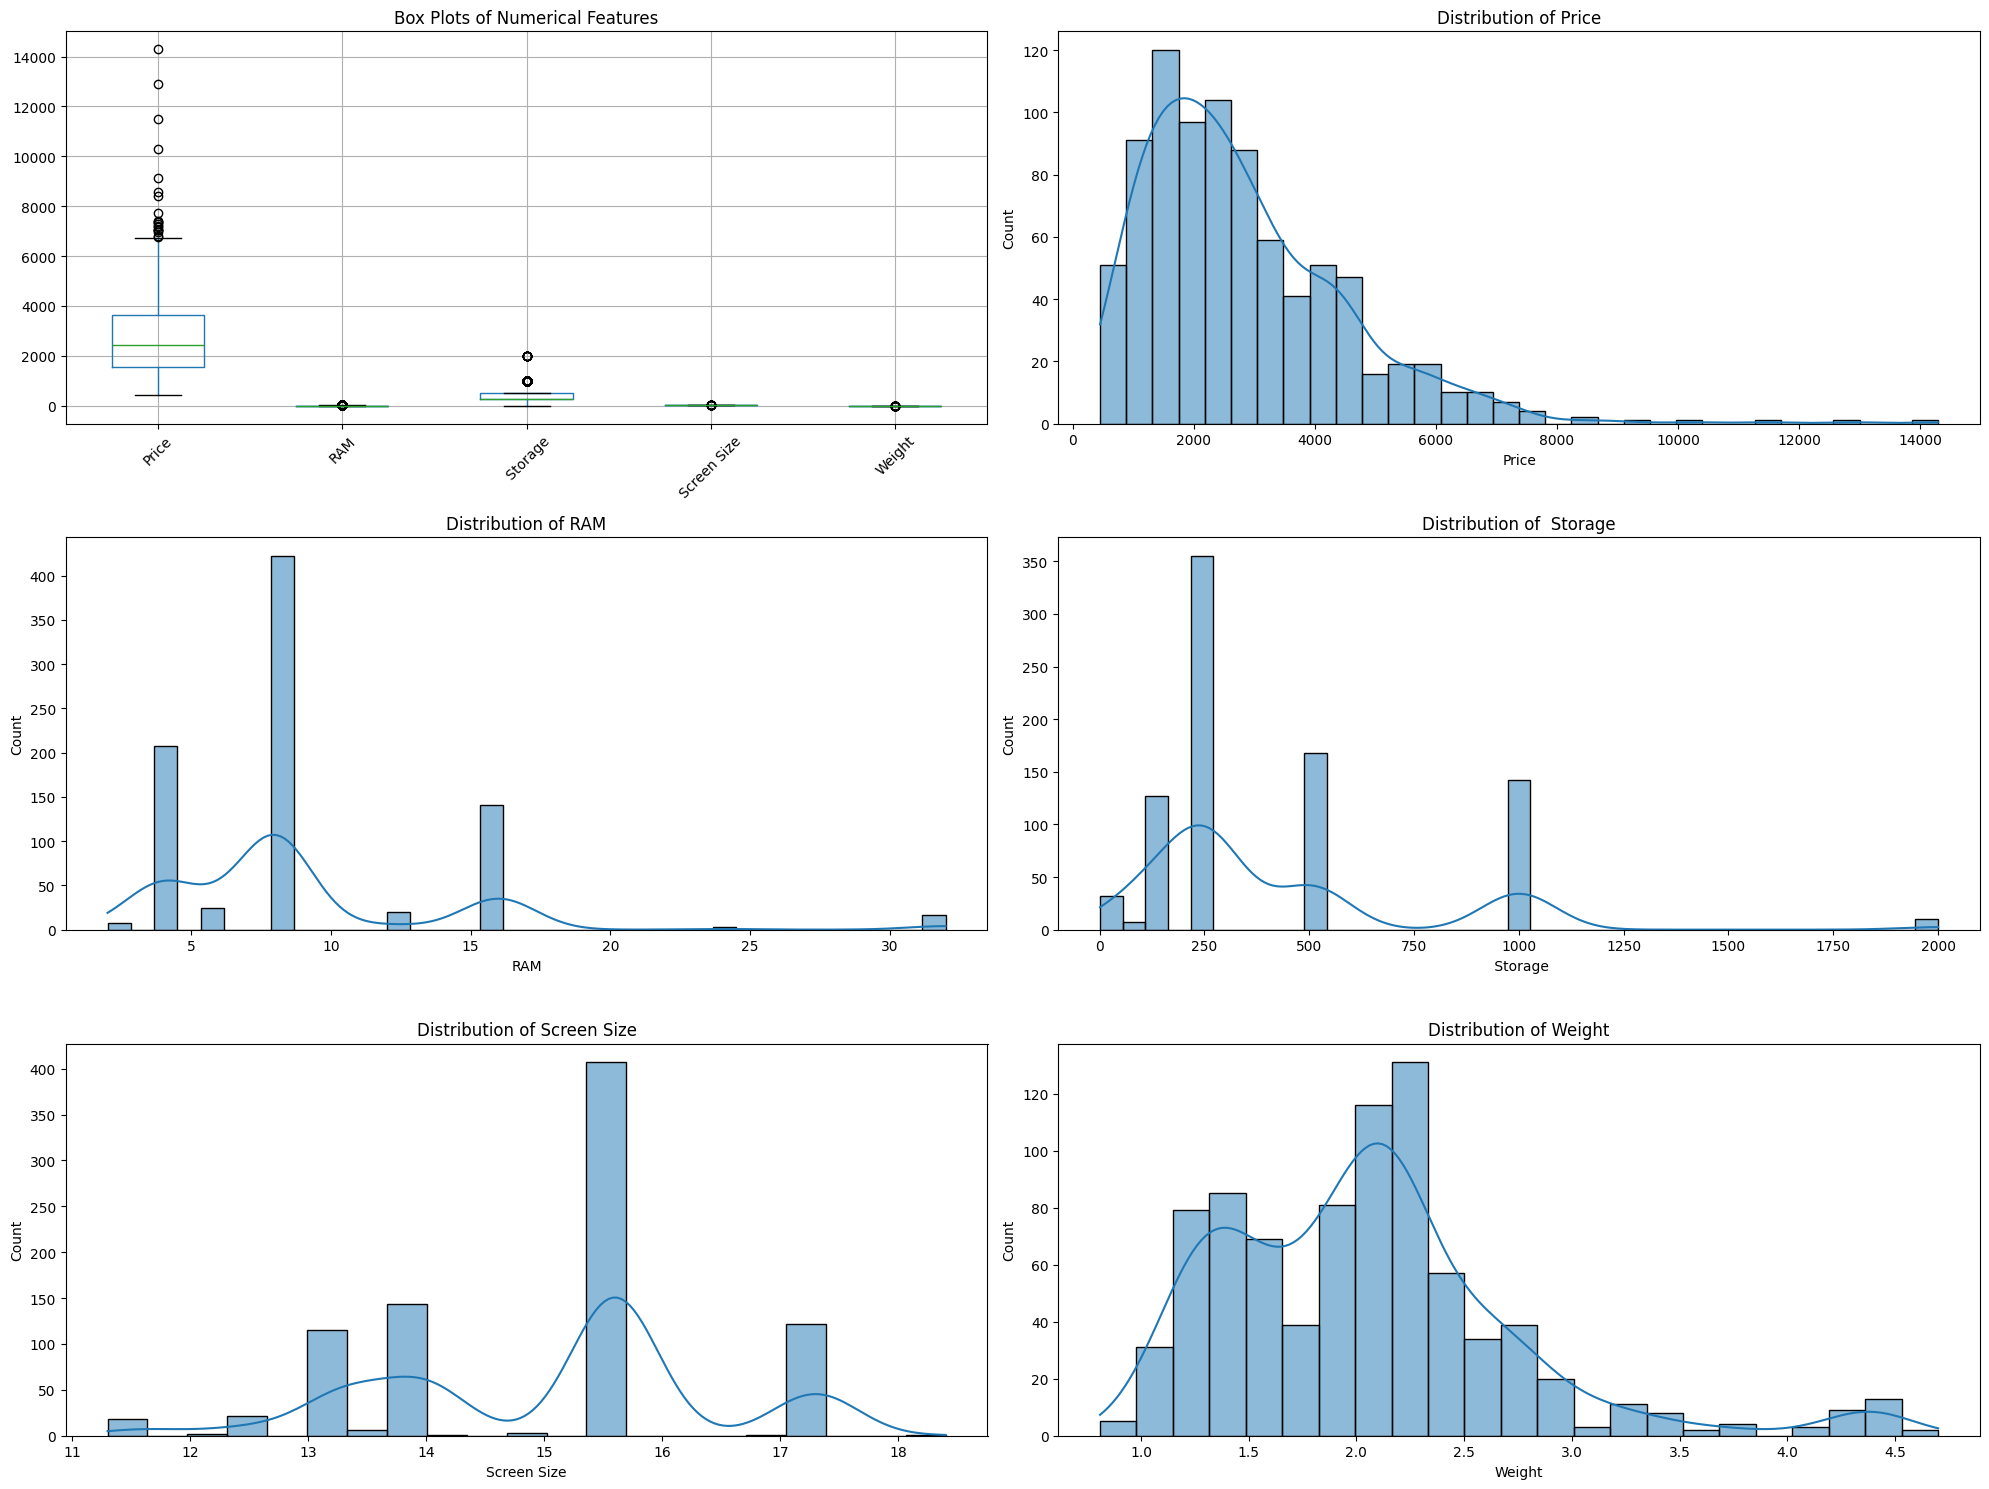


Outlier Statistics:
    Feature Total Values Potential Outliers Outlier Percentage
      Price          841                 20              2.38%
        RAM          841                160             19.02%
    Storage          841                152             18.07%
Screen Size          841                 19              2.26%
     Weight          841                 33              3.92%

Recommendation for LOF analysis:
Based on the analysis, RAM has the most potential outliers (19.02%) and should be prioritized for LOF analysis.


In [76]:
def visualize_outliers(df):
    """Create comprehensive EDA visualizations for outlier analysis"""
    numerical_features = ['Price', 'RAM', ' Storage', 'Screen Size', 'Weight']
    
    # Create figure for all plots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Box plots
    plt.subplot(3, 2, 1)
    df.boxplot(column=numerical_features)
    plt.xticks(rotation=45)
    plt.title('Box Plots of Numerical Features')
    
    # 2. Distribution plots
    for i, feature in enumerate(numerical_features, 2):
        plt.subplot(3, 2, i)
        sns.histplot(data=df, x=feature, kde=True)
        plt.title(f'Distribution of {feature}')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display outlier statistics
    stats = pd.DataFrame(columns=['Feature', 'Total Values', 'Potential Outliers', 'Outlier Percentage'])
    
    for feature in numerical_features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR))]
        
        stats = pd.concat([stats, pd.DataFrame({
            'Feature': [feature],
            'Total Values': [len(df)],
            'Potential Outliers': [len(outliers)],
            'Outlier Percentage': [f"{(len(outliers)/len(df)*100):.2f}%"]
        })]).reset_index(drop=True)
    
    print("\nOutlier Statistics:")
    print(stats.to_string(index=False))
    
    return stats

# Perform EDA visualization
outlier_stats = visualize_outliers(encoded_laptopData)

# Print recommendation
print("\nRecommendation for LOF analysis:")
stats_sorted = outlier_stats.sort_values(by='Potential Outliers', ascending=False)
print(f"Based on the analysis, {stats_sorted.iloc[0]['Feature']} has the most potential outliers "
      f"({stats_sorted.iloc[0]['Outlier Percentage']}) and should be prioritized for LOF analysis.")

Although RAM and Storage have the most outliers due to the nature of the data they shouldn't be removed. The price outliers are a much more significant problem, because it differs so significantly from the rest of the data. Having a few super high end laptops skews the data significantly.

Original Price Distribution:
count      841.000000
mean      2796.103339
std       1682.212396
min        449.859891
25%       1568.297380
50%       2416.912704
75%       3631.229659
max      14297.527237
Name: Price, dtype: float64

Price Distribution After Outlier Handling:
count     821.000000
mean     2659.306419
std      1414.982576
min       449.859891
25%      1544.854968
50%      2348.929708
75%      3514.017598
max      6725.604635
Name: Price, dtype: float64


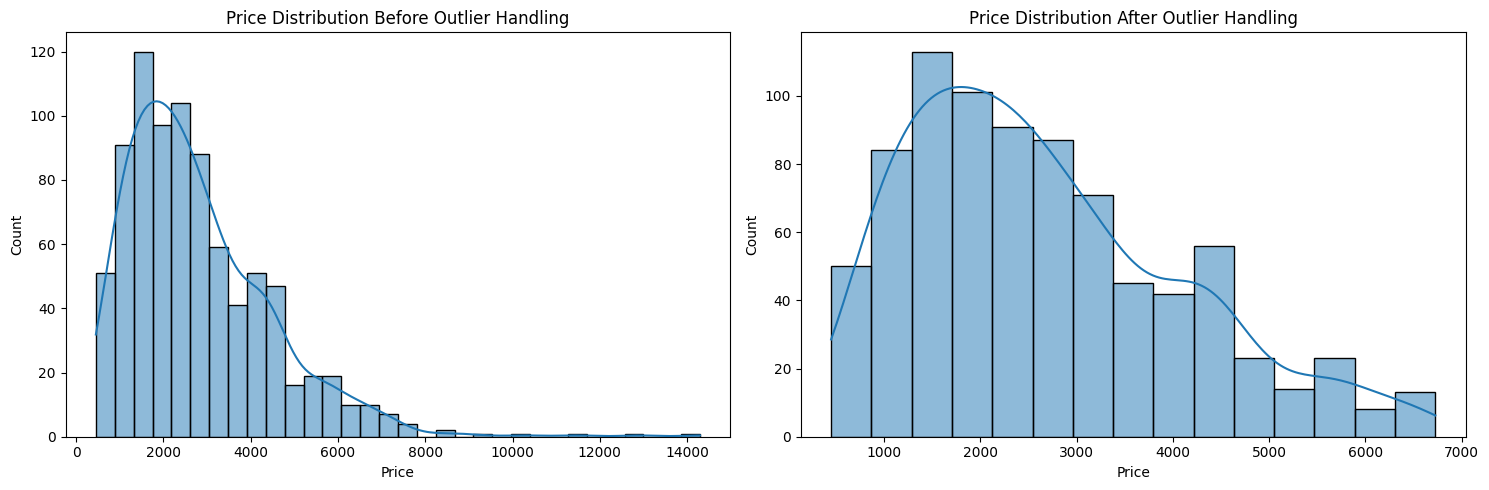

In [77]:
print("Original Price Distribution:")
print(encoded_laptopData['Price'].describe())

def handle_price_outliers(df, method='remove'):
    """Handle price outliers using IQR method"""
    df_clean = df.copy()
    
    # Calculate IQR for price
    Q1 = df_clean['Price'].quantile(0.25)
    Q3 = df_clean['Price'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove or cap outliers
    if method == 'remove':
        df_clean = df_clean[(df_clean['Price'] >= lower_bound) & 
                           (df_clean['Price'] <= upper_bound)]
    elif method == 'cap':
        df_clean.loc[df_clean['Price'] < lower_bound, 'Price'] = lower_bound
        df_clean.loc[df_clean['Price'] > upper_bound, 'Price'] = upper_bound
    
    print("\nPrice Distribution After Outlier Handling:")
    print(df_clean['Price'].describe())
    
    return df_clean

# After your existing EDA code, add:
# Handle price outliers (choose either 'remove' or 'impute')
no_outlier_data = handle_price_outliers(encoded_laptopData, method='remove')

# Display price distribution before and after
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=encoded_laptopData, x='Price', kde=True)
plt.title('Price Distribution Before Outlier Handling')

plt.subplot(1, 2, 2)
sns.histplot(data=no_outlier_data, x='Price', kde=True)
plt.title('Price Distribution After Outlier Handling')

plt.tight_layout()
plt.show()

**Feature Engineering**

Adding 2 features
1. Performance score: taking RAM and Storage capacity to calculate a performance score. Higher RAM and storage typically indicate a higher end laptop and therefore higher performance
2. Portability Score: taking the screen size and weight to calculate a portability score. Smaller screen and lighter weight typically indicate a more portable laptop and therefore higher portability score.

Could also factor in price and Performance score together to see whats a good bang for your buck


In [82]:
def engineer_features(df):
    """Create new features through aggregation and combination"""
    df_engineered = df.copy()
    
    # 1. Performance Score: RAM is factored in more than Storage
    df_engineered['Performance_Score'] = (df_engineered['RAM'] * 0.6 + 
                                        df_engineered[' Storage'] * 0.4) / 100
    
    # 2. Portability Score: equal weighting to both Screen Size and Weight
    max_screen = df_engineered['Screen Size'].max()
    max_weight = df_engineered['Weight'].max()
    
    df_engineered['Portability_Score'] = (
        (1 - df_engineered['Screen Size'] / max_screen) * 0.5 +
        (1 - df_engineered['Weight'] / max_weight) * 0.5
    ) * 100

    print("\nNew Feature Statistics:")
    print("\nPerformance Score Summary:")
    print(df_engineered['Performance_Score'].describe())
    print("\nPortability Score Summary:")
    print(df_engineered['Portability_Score'].describe())

    return df_engineered

engineered_laptopData = engineer_features(no_outlier_data)


New Feature Statistics:

Performance Score Summary:
count    821.000000
mean       1.732804
std        1.384373
min        0.028000
25%        1.072000
50%        1.072000
75%        2.120000
max        8.072000
Name: Performance_Score, dtype: float64

Portability Score Summary:
count    821.000000
mean      37.249007
std       10.345131
min        2.173913
25%       32.608696
50%       35.869565
75%       46.413043
max       57.826087
Name: Portability_Score, dtype: float64


**Empirical Study**

Baseline using Mean Square Error (MSE) and no outliers or feature engineering

In [95]:
def baseline_model(df):
    """Evaluate baseline linear regression model with cross-validation using RMSE"""
    
    # Separate features and target
    X = df.drop(['Price', 'Model Name'], axis=1)
    y = df['Price']
    
    # Normalize prices to be between 0 and 1
    y = (y - y.min()) / (y.max() - y.min())
    
    # Split into train (64%), validation (16%), and test (20%)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
    
    # Create baseline model
    baseline_model = LinearRegression()
    
    # Perform 4-fold cross-validation with MSE
    mse_scores = cross_val_score(baseline_model, X_train, y_train, 
                               cv=4, scoring='neg_mean_squared_error')
    
    # Convert MSE to RMSE
    rmse_scores = np.sqrt(-mse_scores)
    
    # Print cross-validation results
    print("\nCross-validation results (4-fold):")
    print(f"RMSE scores (normalized): {rmse_scores}")
    print(f"Average RMSE (normalized): {rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")
    
    # Fit model on entire training set and evaluate on validation set
    baseline_model.fit(X_train, y_train)
    y_val_pred = baseline_model.predict(X_val)
    
    print("\nValidation Set Performance:")
    print(f"RMSE (normalized): {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")
    
    return {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'baseline_model': baseline_model
    }
    
baseline_regression = baseline_model(encoded_laptopData)


Cross-validation results (4-fold):
RMSE scores (normalized): [2.87736880e+07 6.64281667e-02 5.68624209e-02 4.19789417e+06]
Average RMSE (normalized): 8242895.5853 (+/- 23953415.8088)

Validation Set Performance:
RMSE (normalized): 11718685.7029


Now testing with outliers and feature aggregation to see which one works best


Evaluating Baseline:

Cross-validation results (4-fold):
R² scores: [-3.62817953e+16  7.42403615e-01  6.32359796e-01 -1.23627304e+15]
Average R²: -9379517073692592.0000 (+/- 31080470966425800.0000)
MSE scores: [8.27925124e+14 4.41270133e-03 3.23333491e-03 1.76223154e+13]
Average MSE: 211386859857467.25 (+/- 712062454311873.62)

Validation Set Performance:
R²: -11008162144457796.0000
MSE: 137327594603863.73

Evaluating No Outliers:

Cross-validation results (4-fold):
R² scores: [-1.19213259e+16  6.67336057e-01 -1.55441540e+18  6.06957172e-01]
Average R²: -391584181558919616.0000 (+/- 1342757114946093568.0000)
MSE scores: [5.70809127e+14 1.71850931e-02 8.00603091e+16 1.64694926e-02]
Average MSE: 20157779563676912.00 (+/- 69171053287369168.00)

Validation Set Performance:
R²: -28745323176515764.0000
MSE: 1920011851513331.50

Evaluating With Feature Aggregation:

Cross-validation results (4-fold):
R² scores: [-1.00727835e+15 -1.14685972e+16 -8.06515297e+15 -4.07196884e+18]
Average R²: -10

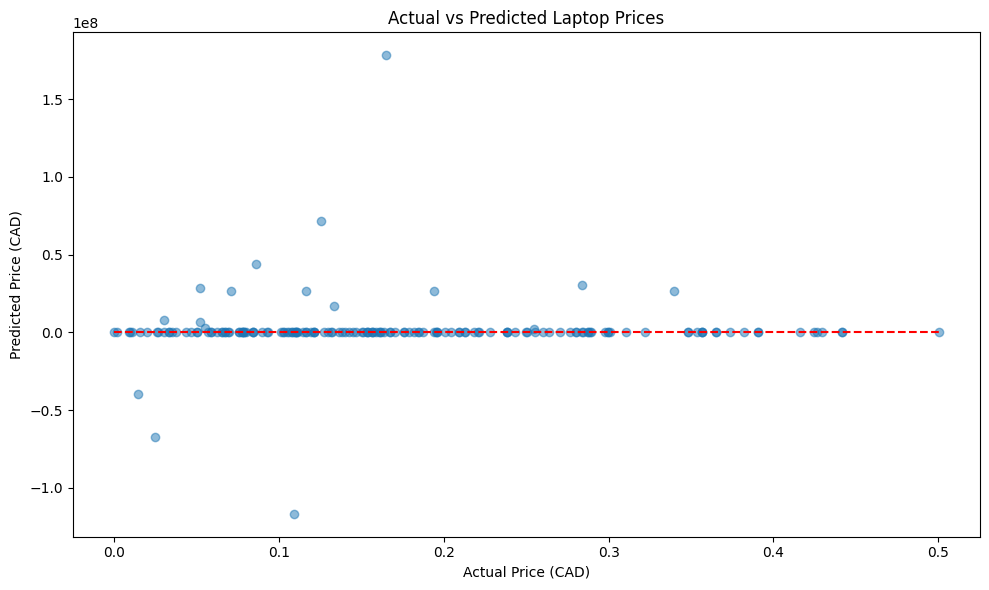

In [111]:
def evaluate_model_configurations(df, with_outliers=True, with_feature_agg=False):
    """Evaluate different model configurations using R² and MSE"""
    
  
    if not with_outliers:
        df = no_outlier_data
    elif with_feature_agg:
        df = engineered_laptopData
    
    # Separate features and target
    X = df.drop(['Price', 'Model Name'], axis=1)
    y = df['Price']

    y = (y - y.min()) / (y.max() - y.min())

    
    # Split into train+val (80%) and test (20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
    
    # Create and train model
    model = LinearRegression()
    
    # Perform 4-fold cross-validation for both metrics
    r2_scores = cross_val_score(model, X_train, y_train, cv=4, scoring='r2')
    mse_scores = cross_val_score(model, X_train, y_train, cv=4, scoring='neg_mean_squared_error')
    mse_scores = -mse_scores
    
    # Train on full training set and evaluate on validation set
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    val_r2 = r2_score(y_val, val_pred)
    val_mse = mean_squared_error(y_val, val_pred)
    
    # Print results
    print(f"\nCross-validation results (4-fold):")
    print(f"R² scores: {r2_scores}")
    print(f"Average R²: {r2_scores.mean():.4f} (+/- {r2_scores.std()*2:.4f})")
    print(f"MSE scores: {mse_scores}")
    print(f"Average MSE: {mse_scores.mean():.2f} (+/- {mse_scores.std()*2:.2f})")
    
    print(f"\nValidation Set Performance:")
    print(f"R²: {val_r2:.4f}")
    print(f"MSE: {val_mse:.2f}")
    
    return {
        'cv_r2': r2_scores.mean(),
        'cv_mse': mse_scores.mean(),
        'val_r2': val_r2,
        'val_mse': val_mse,
        'model': model,
        'X_test': X_test,
        'y_test': y_test
    }

# Test all configurations
configurations = [
    {'outliers': True, 'feature_agg': False, 'name': 'Baseline'},
    {'outliers': False, 'feature_agg': False, 'name': 'No Outliers'},
    {'outliers': True, 'feature_agg': True, 'name': 'With Feature Aggregation'},
]

results = {}
for config in configurations:
    print(f"\nEvaluating {config['name']}:")
    results[config['name']] = evaluate_model_configurations(
        encoded_laptopData,
        with_outliers=config['outliers'],
        with_feature_agg=config['feature_agg']
    )

# Find best configuration based on validation R² (higher is better)
# If R² values are problematic, we can use MSE (lower is better)
try:
    # First try using R²
    best_config = max(results.items(), key=lambda x: x[1]['val_r2'])
    metric_used = "R²"
except:
    # If that fails, use MSE
    best_config = min(results.items(), key=lambda x: x[1]['val_mse'])
    metric_used = "MSE"

print(f"\nBest configuration based on validation {metric_used}: {best_config[0]}")

# Final evaluation on test set
best_model = best_config[1]['model']
X_test = best_config[1]['X_test']
y_test = best_config[1]['y_test']

# Make predictions on test set
test_pred = best_model.predict(X_test)

# Calculate final metrics
test_r2 = r2_score(y_test, test_pred)
test_mse = mean_squared_error(y_test, test_pred)

print(f"\nFinal Test Set Results:")
print(f"R²: {test_r2:.4f}")
print(f"MSE: {test_mse:.2f}")

# Visualize actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price (CAD)')
plt.ylabel('Predicted Price (CAD)')
plt.title('Actual vs Predicted Laptop Prices')
plt.tight_layout()
plt.show()


**Results Discussion**

For some reason the MSE and R^2 scores of all of the configurations are insanely large. I couldn't figure out why this is and many of my attempts to fix it failed. I tried normalizing, standardizing and scaling but nothing had a notable impact on the results. In the end I somehow gathered that the baseline model performed the best. If the scatterplot is correct then there are a few outlier price guesses that completely skew the data to a massive degree. With the numbers going as large as 1x10^8 I would assume that the outliers are the reason for this. I have no idea why the data doesn't perform better with the outliers removed. Even if the aggregated features mess with the data the outliers being removed should still improve the overall results yet they do not.

**References**

Much of the code was based on and adapted from code I found on the website GeeksForGeeks. As well as Sci-kit Learns actual website and the slides from class.

https://www.geeksforgeeks.org/ml-linear-regression/